# Topic Modelの動作確認

In [1]:
import analysisNLP
import gensim
import numpy as np
from collections import Counter
from sklearn import datasets
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import re
%matplotlib inline

# データ準備
* 利用データ：https://www.rondhuit.com/download.html#ldcc

In [3]:
fname = '/home/share/suzuki_motoya/ameblo/data/34_高品質記事のテキスト特徴/indata.csv'
docs = []
for i in open(fname, 'r'):
    ii = i.strip('\n').split(',')
    if 'url' != ii[0]:
        docs.append([ii[0], ' '.join(ii[1:])])

In [2]:
with open('data.txt', 'r') as f:
    docs = []
    text_str = ''
    for text in f:
        if text[:25] == 'http://news.livedoor.com/' and text_str != '':
            docs.append([key_str, text_str])
            text_str = ''
        if text[:25] != 'http://news.livedoor.com/' and len(text.strip('\n')) != 24 and text[0] != '2':
            text_str += text.strip('\n')   
        if text[:25] == 'http://news.livedoor.com/':
            key_str = text.strip('\n')

FileNotFoundError: [Errno 2] No such file or directory: 'data.txt'

In [4]:
# 確認
print(docs[:1])
print('件数 ' + str(len(docs)))

[['https://ameblo.jp/pr-ameba-browlash/entry-12410988014.html', '崩れ 美人 眉 ジェルペンシルウォーターストロング ハイキングデート 秘密 道具 ラッシュ 気 崩れ 汗 自体 汗 皮脂 アイライナー アイブロウ メイン ラッシュ シリーズ ラッシュ ウォーターストロングライナー N コシ リキッドフェルトペン 汗 水 皮脂 お湯 眉 ラッシュ ウォーター W カラー 画像 種類 ラッシュ ウォーター W アイブロウ ジェルペンシル パウダー 仕上がり 眉 ラッシュ ウォーター W アイブロウ ペンシル 美人 眉 最適 眉毛 ジム プール 汗 ラッシュ ブロウコーティング 眉毛 トップコート 水 眉 汗 シチュエーション 子供 おばさん 大人 女子']]
件数 10000


In [24]:
with open('data.tsv', 'w') as f:
    for i in docs:
        f.write('\t'.join(i) + '\n')

# 形態素解析

In [20]:
m = analysisNLP.MecabWrapper(dicttype='neologd')
texts = [m.tokenize(sentence=doc[1], pos_filter=[['名詞', '一般', '*']], is_list=True)
         for doc in docs]
texts[0][:10]

['崩れ',
 '美人',
 '眉',
 'ジェルペンシルウォーターストロングハイキングデート',
 '秘密',
 '道具',
 'ラッシュ',
 '気',
 '崩れ',
 '汗']

In [21]:
# termカウント
count = Counter(w for doc in texts for w in doc)
count.most_common(10)

[('自分', 7472),
 ('夫', 3750),
 ('息子', 3483),
 ('記事', 3438),
 ('旦那', 3008),
 ('ー', 2959),
 ('先生', 2865),
 ('気持ち', 2788),
 ('感じ', 2633),
 ('ママ', 2613)]

In [56]:
max_frequency = count.most_common()[N][1]
max_frequency
num_tokens = len(count)
N = int(num_tokens*0.05)
print(num_tokens,N)

47314 2365


In [7]:
# 頻度が多いtermや少ないtermを除外
num_tokens = len(count)
N = int(num_tokens*0.05)
max_frequency = count.most_common()[N][1]
#texts = [[w for w in doc if max_frequency > count[w] >= 3] for doc in texts]

r = re.compile("^[ぁ-んァ-ン0-9a-zA-Z]$")
texts = [[w for w in doc if max_frequency > count[w] >= 3 and not re.match(r,w)] for doc in texts]

In [19]:
# termカウント
count = Counter(w for doc in texts for w in doc)
count.most_common(10)

[('脚本', 38),
 ('図書', 38),
 ('指先', 38),
 ('内臓', 38),
 ('旗', 38),
 ('コロッケ', 38),
 ('手頃', 38),
 ('角形', 38),
 ('ざく', 38),
 ('アメーバ', 38)]

In [8]:
print(num_tokens)
print(N)

47314
2365


# コーパス作成

In [22]:
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
corpus[0]

[(0, 1),
 (1, 3),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 3),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 5),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 4),
 (27, 1),
 (28, 1),
 (29, 2),
 (30, 5),
 (31, 2),
 (32, 1),
 (33, 1),
 (34, 2),
 (35, 1),
 (36, 1)]

# トピックモデル作成

In [23]:
num_topics = 100
lda = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    iterations=100,
    alpha='auto'
)

/home/share/suzuki_motoya/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [25]:
topic_counnter = Counter(topic[0] for doc in lda[corpus] for topic in doc if topic[1] > 0.0).most_common()

In [26]:
topic_list = list(pd.DataFrame(topic_counnter)[0])[:20]

In [27]:
df_docweight = pd.DataFrame([{topic[0]:topic[1] for topic in doc if topic[1] > 0.0} for doc in lda[corpus]])\
        .join(pd.DataFrame(docs,columns=['url', 'text']).iloc[:,0], how='inner')

In [14]:
df_top_weight = pd.DataFrame()
for i in topic_list:
    df_top_weight_org = df_docweight.sort_values(i, ascending=False).head(10).loc[:,['url',i]].rename(columns={i: 'weight'})
    df_top_weight_org['topic'] = i
    df_top_weight = pd.concat([df_top_weight, df_top_weight_org[['topic', 'url', 'weight']]])
df_top_weight

,topic,url,weight
1500,12,https://ameblo.jp/happines-rescue/entry-124088...,0.969316
734,12,https://ameblo.jp/tkmmf2/entry-12409510566.html,0.952658
1325,12,https://ameblo.jp/moe-pin9/entry-12414067341.html,0.935021
1765,12,https://ameblo.jp/arimama123/entry-12409597281...,0.931613
204,12,https://ameblo.jp/lifewithboys/entry-124101710...,0.925979
283,12,https://ameblo.jp/1983115/entry-12131090487.html,0.925807
1138,12,https://ameblo.jp/cheers-plumeria/entry-124099...,0.913549
422,12,https://ameblo.jp/kimochiwotsuduru/entry-12411...,0.913549
432,12,https://ameblo.jp/qj0721/entry-12413139863.html,0.913549
1116,12,https://ameblo.jp/happines-rescue/entry-124123...,0.911850


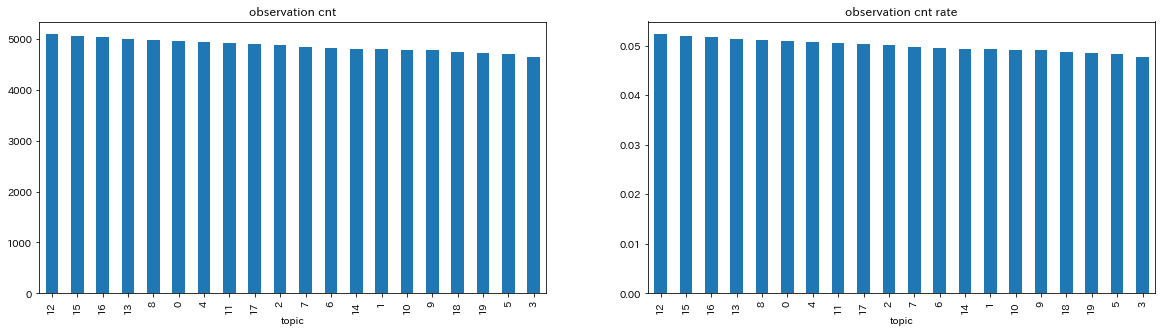

In [24]:
def make_barchart(df):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.title('observation cnt')
    (df['cnt']).head(50).plot.bar()
    plt.subplot(1, 2, 2)
    plt.title('observation cnt rate')
    (df['cnt'] / np.sum(df['cnt'])).head(50).plot.bar()
    plt.show()

make_barchart(pd.DataFrame(topic_counnter, columns=['topic', 'cnt']).set_index('topic'))

# ワードクラウドで可視化

In [18]:
lda.show_topic(12,200)

[('競馬', 0.0077976706),
 ('前世', 0.0065370398),
 ('業務', 0.006442746),
 ('月刊', 0.0063974094),
 ('論文', 0.006182855),
 ('持ち込み', 0.00576092),
 ('乳ガン', 0.005731536),
 ('見直し', 0.005394603),
 ('老後', 0.005328078),
 ('骨格', 0.0052609676),
 ('異色', 0.0052427766),
 ('火水', 0.0052366867),
 ('理性', 0.0047253375),
 ('有給', 0.004623048),
 ('レン', 0.004462682),
 ('デイリー', 0.0043014525),
 ('事務', 0.004167941),
 ('Movie', 0.0041192365),
 ('祈り', 0.0040456415),
 ('水木', 0.004011704),
 ('フルタイム', 0.004009477),
 ('最短', 0.0039424086),
 ('足首', 0.0039011787),
 ('昼休み', 0.00384452),
 ('拠点', 0.0038232435),
 ('おっちゃん', 0.0036932474),
 ('横並び', 0.0036771207),
 ('レジャー', 0.0036254437),
 ('見栄', 0.0034666026),
 ('選び方', 0.0034566529),
 ('ガイドライン', 0.0034484125),
 ('着丈', 0.0033844984),
 ('口角', 0.0033688017),
 ('土鍋', 0.0033589103),
 ('カフェイン', 0.0033582451),
 ('実父', 0.0033049178),
 ('もん', 0.0032663676),
 ('マイレピ', 0.0032617238),
 ('すき焼き', 0.0031828596),
 ('ヒロイン', 0.0031809409),
 ('乳腺', 0.0031758803),
 ('持ち味', 0.0031621146),
 ('薬局', 0.0031

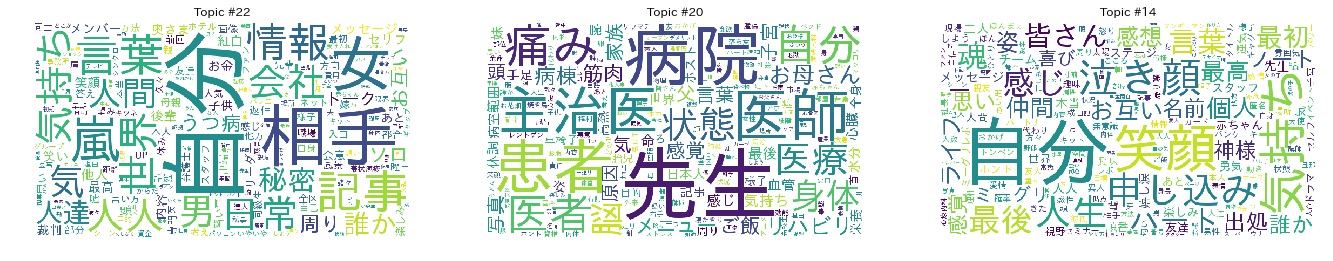

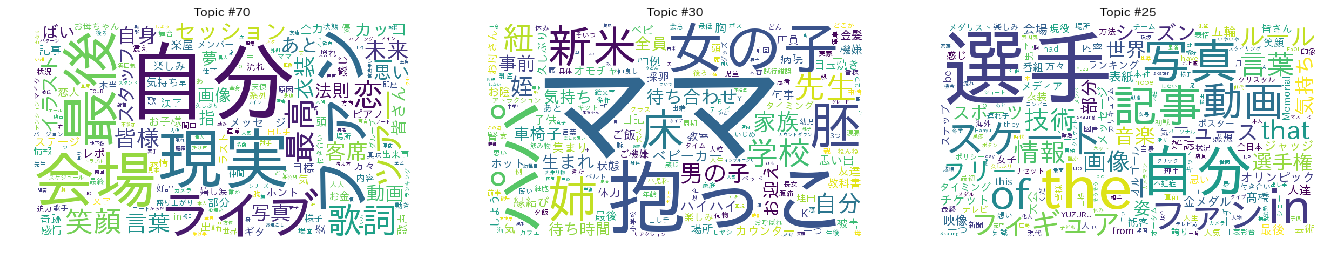

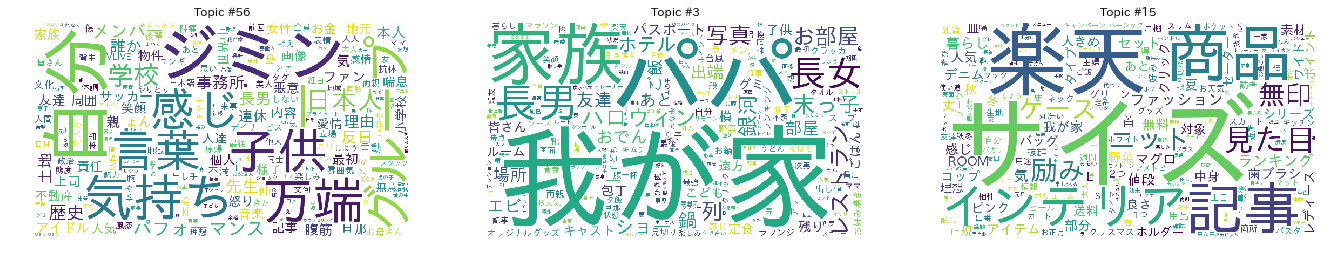

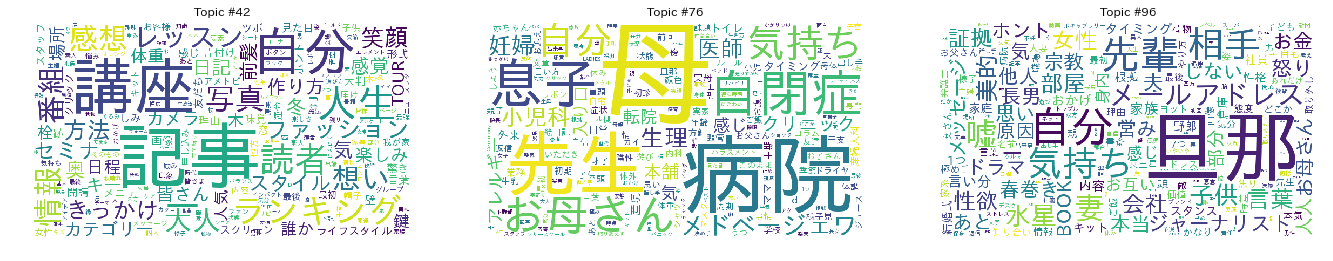

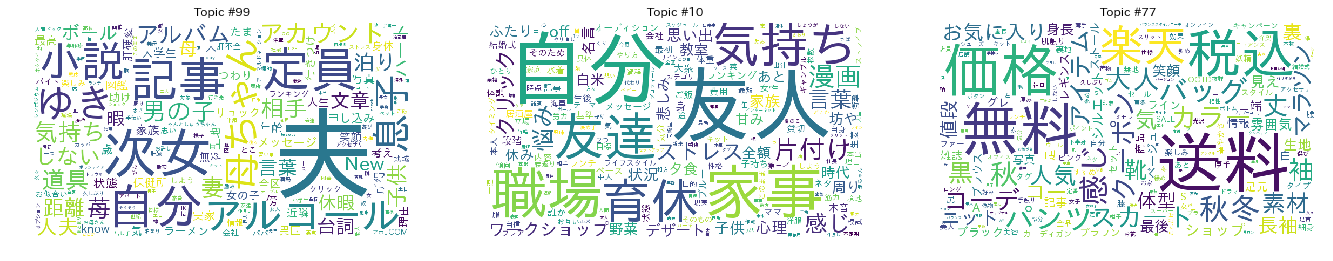

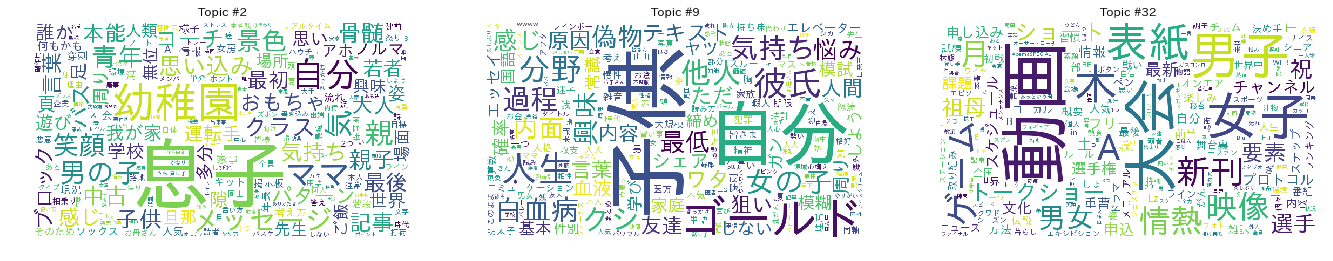

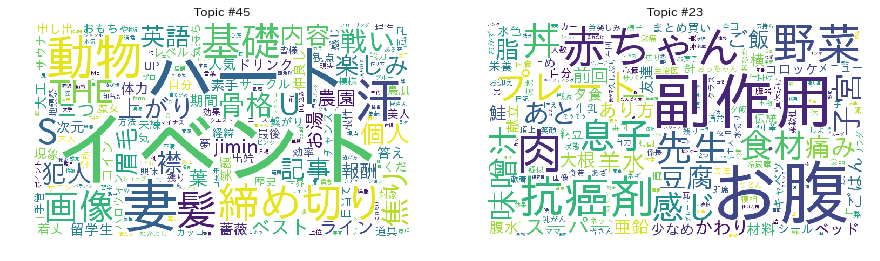

In [28]:
fpath = '../analysisNLP/.fonts/ipaexg.ttf'
pltot_count = 20
loop_count = int(np.ceil(pltot_count / 3))
for i in range(loop_count):
    plt.figure(figsize=(23,loop_count*10))
    for t in range(3*(i),3*(i+1)):
        if t+1 <= pltot_count:
            topic = topic_list[t]
            plt.subplot(loop_count,3,t+1)
            x = dict(lda.show_topic(topic,200))
            im = WordCloud(background_color="white",font_path=fpath,width=700,height=400).generate_from_frequencies(x)
            plt.imshow(im)
            plt.axis("off")
            plt.title("Topic #" + str(topic))
    plt.show()